In [1]:
import os
import numpy as np
import pandas as pd
import librosa, librosa.display
from util import *

from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# Data Extraction

The data extraction is handled in a seperate script extract_audio_features.ipynb. The script breaks down the audio files into small chunks and extracts the features from each of the audio chunks and store them all into the .csv file. 1 out of the 1,000 audio files is corrupted and not used for analysis. Otherwise, the 999 audio files are processed by extract_audio_features.ipynb to create 9990 rows of data features stored in the .csv file for model training.

# Exploratory Data Analysis

In [2]:
# audio_features_3_sec.csv is the output csv file from the data extraction steps.
df = pd.read_csv("./data/audio_features_3_sec.csv")
print("Date shape: {}".format(df.shape))
df.head(5)

Date shape: (9685, 58)


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,pop.00027.0.wav,66150,0.354070,0.092004,0.133745,0.002745,3041.383942,7.140194e+05,3126.119651,180625.664149,...,75.57889,-1.411003,99.614210,-0.176044,120.819330,-0.039866,78.574684,-3.026498,86.39399,pop
1,pop.00027.1.wav,66150,0.346957,0.089579,0.143777,0.001806,2922.334626,1.250350e+06,2960.381766,225852.280494,...,75.58028,-6.210502,64.975590,-2.355854,87.215120,0.570278,94.365520,3.037296,105.46779,pop
2,pop.00027.2.wav,66150,0.328392,0.090207,0.130174,0.002610,2802.174545,7.740314e+05,3067.712826,229109.502454,...,76.66625,-1.685729,116.244995,-0.341337,114.137760,-0.482767,104.127144,-3.239160,106.19654,pop
3,pop.00027.3.wav,66150,0.310396,0.079919,0.171010,0.002549,2723.966562,9.677586e+05,2968.551682,172274.167333,...,159.05185,-1.928844,140.865980,-3.151660,95.238190,-8.257116,86.091090,-8.010163,141.83983,pop
4,pop.00027.4.wav,66150,0.440510,0.085436,0.148661,0.002220,2377.343178,8.584688e+05,2897.081914,198226.454488,...,32.92679,-1.269860,46.452496,-0.986701,28.281462,-3.069594,39.764366,-8.417820,50.49454,pop


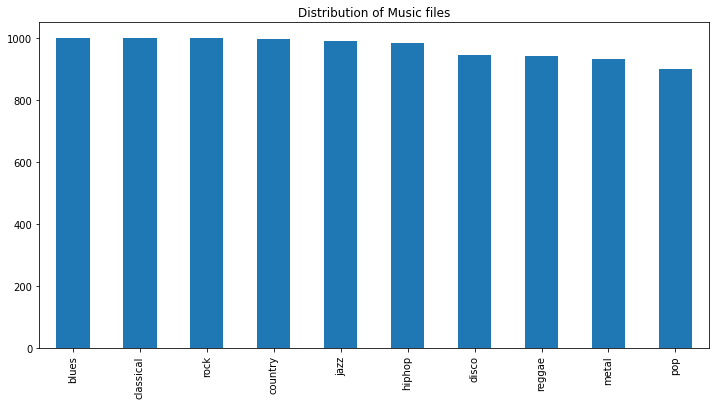

In [3]:
graph = df["label"].value_counts()
graph.plot.bar(x=graph.keys(), 
               y=graph.values, 
               title="Distribution of Music files",
               figsize=(12,6));

plt.show(block=True);

## Data Preparation

Preprocessing of data is required before we actually train the data. The label column will be encoded using the LabelEncoder() function from sklearn.preprocessing. The class and label encoding will then be persisted into a .pkl file which will be loaded before doing inferences of individual audio files.

In [4]:
from sklearn.preprocessing import LabelEncoder

class_list = df.iloc[:,-1]
converter = LabelEncoder()
y = converter.fit_transform(class_list)
y.shape

(9685,)

In [5]:
import pickle

mapping = dict(zip(converter.transform(converter.classes_), converter.classes_))
print(mapping)

f = open("mapping.pkl","wb")
pickle.dump(mapping,f)
f.close()

{0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}


## Data scaling

The data is scaled by using the StandardScaler from sklearn to standardize the features by removing the mean and scaling to unit variance. Once the StandardScaler is fitted to the dataset, the StandardScaler is persisted into a .bin using the joblib.dump function. The StandardScaler will be loaded from the .bin file to scale the into data before doing model inference.

In [6]:
from sklearn.preprocessing import StandardScaler
from joblib import dump

scaler = StandardScaler()
df = df.drop(labels=["filename", "label"],axis=1)
X = scaler.fit_transform(df)
dump(scaler, 'standardscaler.bin', compress=True)

['standardscaler.bin']

## Dividing Training and Testing Dataset

Use the train_test_split function to split the data into train (80%) and test set (20%). Set the random state so that the data split can be replicated across experiements.

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 41, test_size = 0.20)
print("Train data size: {}, Validation data size: {}".format(len(y_train), len(y_test)))

Train data size: 7748, Validation data size: 1937


## Building the model

We define a deep neural net to be the audio classifier model. The neural net is essentially 6 Dense layers and the final Dense layer has 10 output classes. Each of the Dense layer, except for the final layer, has "RELU" activation function. Add Dropout layers between the Dense layers to prevent overfitting. The model is compiled with Adam optimizer with sparse_categorical_crossentropy loss function.

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [9]:
model = Sequential()
model.add(Dense(1024, input_shape=(X_train.shape[1],), activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(10, activation="softmax"))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              58368     
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               3

2022-05-31 19:02:15.038926: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


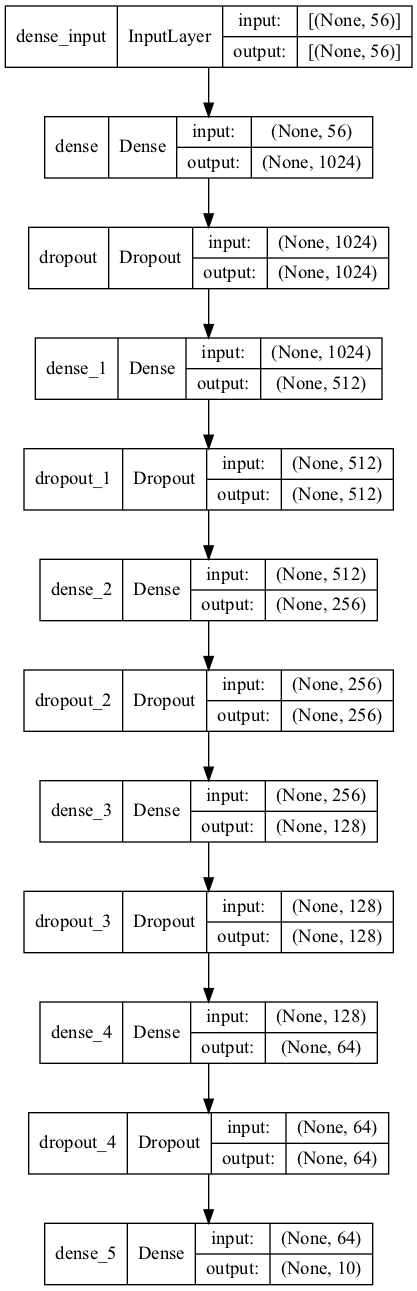

In [23]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='audio_classifier_model.png', show_shapes=True, show_layer_names=True)

# Model Training

We define the model checkpointing to save only the model when the validation accuracy is better than the earlier epoch. We also define EarlyStopping to end the training if the validation accuracy does not improve afer _patience_ number of epochs.

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

batch_size=128
epochs = 100
model_weight = './model/best_weights.hdf5'

best_checkpoint = ModelCheckpoint(model_weight,
                                  save_weights_only=False, 
                                  save_best_only=True,
                                  monitor='val_accuracy',
                                  mode='max',
                                  verbose=1)

early_stop = EarlyStopping(monitor='val_accuracy', 
                           patience=3, 
                           restore_best_weights=True, 
                           mode='max')

history = model.fit(X_train,
                    y_train,
                    validation_data=(X_test,y_test),
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[best_checkpoint, early_stop],
                    verbose=1)

Epoch 1/600
58/61 [===========================>..] - ETA: 0s - loss: 1.5769 - accuracy: 0.4293
Epoch 00001: val_accuracy improved from -inf to 0.62416, saving model to ./model/best_weights.hdf5
61/61 [==============================] - 1s 11ms/step - loss: 1.5635 - accuracy: 0.4352 - val_loss: 1.0832 - val_accuracy: 0.6242
Epoch 2/600
57/61 [===========================>..] - ETA: 0s - loss: 1.0368 - accuracy: 0.6453
Epoch 00002: val_accuracy improved from 0.62416 to 0.71864, saving model to ./model/best_weights.hdf5
61/61 [==============================] - 0s 8ms/step - loss: 1.0357 - accuracy: 0.6467 - val_loss: 0.8308 - val_accuracy: 0.7186
Epoch 3/600
58/61 [===========================>..] - ETA: 0s - loss: 0.8510 - accuracy: 0.7134
Epoch 00003: val_accuracy improved from 0.71864 to 0.75116, saving model to ./model/best_weights.hdf5
61/61 [==============================] - 1s 8ms/step - loss: 0.8497 - accuracy: 0.7140 - val_loss: 0.7327 - val_accuracy: 0.7512
Epoch 4/600
57/61 [=====

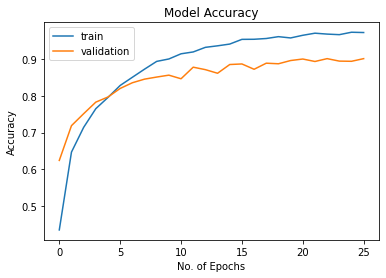

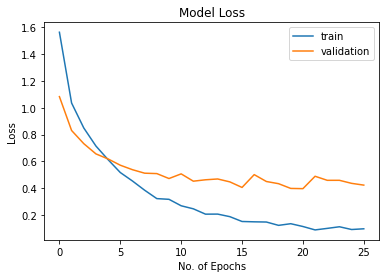

In [11]:
plot_training_graph(history)

# Model Evaluation

In [12]:
test_loss,test_acc = model.evaluate(X_test,y_test,batch_size=128)

print("The test loss is ",test_loss)
print("The best accuracy is: ",test_acc*100)

16/16 [==============================] - 0s 2ms/step - loss: 0.4591 - accuracy: 0.9009
The test loss is  0.4591345489025116
The best accuracy is:  90.08776545524597


# Make Prediction

The individual audio file has to be pre-processed before it can be sent to the train model for inference. Before the audio file is processed, load the:
* model weights
* class label mappings
* Standard Scaler

The audio file will be pre-processed in the following sequence:
* Split the audio file into chunks of smaller 3-seconds chunks
* Extract the features from each of the 3-seconds chunk and store them into a dataframe
* Scale the values in the dataframe using the Standard Scaler

Once the prediction is done - there should be 10 predictions given there are 10 audio chunks for each audio file. The prediction of each audio chunk is done independently and stored into the Counter. The most common value from the Counter will be the overall prediction for the individual audio file.

In [13]:
from data_processing import *
from keras.models import load_model
from joblib import load
import pickle

/Users/christopher_sia/opt/anaconda3/envs/python37/lib/python3.7/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [14]:
model = load_model('./model/best_weights.hdf5')
print("Loading model... done")

label_mapping = pickle.load(open("mapping.pkl", "rb"))
print("Loading label mappings... done")

scaler = load('standardscaler.bin')
print("Loading standard scaler... done")

Loading model... done
Loading label mappings... done
Loading standard scaler... done


In [19]:
audio_file = "./data/metal/metal.00028.wav"
features = pd.DataFrame()
temp_dir = os.path.abspath("temp")

audio_chunks = extract_audio_chunks(audio_file, 3000, temp_dir)

for audio_chunk in audio_chunks:
    features = features.append(extract_features(audio_chunk), ignore_index=True)

clear_folder(temp_dir)

features = features.drop(labels=["filename", "label"],axis=1)
features = scaler.transform(features)
predictions = model.predict(features)

In [20]:
from collections import Counter

prediction = []

for pred in predictions:
    prediction.append(label_mapping[np.argmax(pred)])

prediction = Counter(prediction)
prediction = prediction.most_common()[0][0]
print(prediction)

metal
